# Models

Training and testing models: PSSM, HMM and ensemble of both

In [1]:
# Dependencies
import modules.pssm as pssm
import modules.hmm as hmm
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set matplotlib inline
%matplotlib inline

In [2]:
# Constants
MSA_FASTA_PATH = 'data/msa.fasta'  # Multiple sequence alignment (.fasta)
HUMAN_CSV_PATH = 'data/human.csv'  # Human proteome .csv dataset
HUMAN_FASTA_PATH = 'data/human.fasta'  # Human proteome .fasta dataset
# Families dataset path
FAMILIES_CSV_PATH = 'data/families.csv'  # Families .csv dataset
# Hidden Markov Model paths
HMM_MODEL_PATH = 'models/model.hmm'  # Hidden Markov Model path
# PSSM paths
PSSM_MODEL_PATH = 'models/model.pssm'  # PSSM model path

In [5]:
# Load protein families dataset
ds_human = pd.read_csv(HUMAN_CSV_PATH, sep='\t')
ds_human = ds_human[['entry_ac', 'PF00397']]
ds_human.head()

,entry_ac,PF00397
0,Q9Y263,False
1,Q96RE7,False
2,O43312,False
3,Q9NP80,False
4,Q15319,False


## PSSM model

In [6]:
# Execute PSSM
try:
    pssm_result = pssm.run(test_path=HUMAN_FASTA_PATH, model_path=PSSM_MODEL_PATH)
    pssm_result = pssm.parse(pssm_result)
    
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [7]:
# Check pssm result
pssm_result.head()

,query_acc_ver,subject_acc_ver,perc_identity,align_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,UniRef90_A0A2A9PPS1,Q8N3X1,22.951,61,47,0,71,131,598,658,4.63e-08,53.9
1,UniRef90_A0A2A9PPS1,Q96J02,11.915,235,200,3,17,251,275,502,1.38e-07,52.4
2,UniRef90_A0A2A9PPS1,Q96J02,15.464,97,81,1,56,152,426,521,2.50e-04,42.4
3,UniRef90_A0A2A9PPS1,O00308,13.284,271,222,6,1,261,227,494,1.61e-07,52.0
4,UniRef90_A0A2A9PPS1,O00308,9.677,217,192,2,20,233,282,497,2.94e-06,48.1


In [26]:
# Define set of positive protein accessions
pred_positive = set(pssm_result.subject_acc_ver)
pred_negative = set(ds_human['entry_ac']) - pred_positive

print('There are {:d} positive  and {:d} negative proteins matched by PSSM'.format(
    len(pred_positive), len(pred_negative)
))

There are 45 positive  and 20322 negative proteins matched by PSSM


In [27]:
# Define set of truly positive protein accessions
positive = set(ds_human[ds_human['PF00397']]['entry_ac'])
negative = set(ds_human['entry_ac']) - positive

print('There are {:d} positive and {:d} negative proteins in human proteome'.format(
    len(positive), len(negative)
))

There are 38 positive and 20329 negative proteins in human proteome


In [28]:
# Define confusion matrix entries
true_positive = positive & pred_positive
false_positive = negative & pred_positive
true_negative = negative & pred_negative
false_negative = positive & pred_negative

print('There are:')
print('{:d} true positive'.format(len(true_positive)))
print('{:d} false positive'.format(len(false_positive)))
print('{:d} true negative'.format(len(true_negative)))
print('{:d} false negative'.format(len(false_negative)))

There are:
33 true positive
12 false positive
20317 true negative
5 false negative


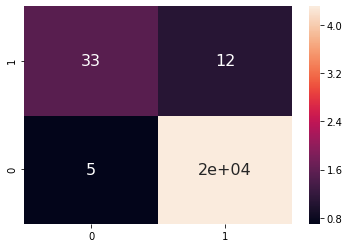

In [29]:
# Create confusion matrix
conf_matrix = np.array([[len(false_negative), len(true_negative)],
                       [len(true_positive), len(false_positive)]])

# Plot confusion matrix
fig, ax = plt.subplots()
_ = sns.heatmap(np.log10(conf_matrix), ax=ax, annot=conf_matrix, annot_kws={
    'size': 16, 'ha': 'center', 'va': 'center'
})
_ = ax.set_ylim(0, conf_matrix.shape[0])
_ = plt.show()

## HMM model

In [14]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    hmm_result = hmm.run(msa_path=MSA_FASTA_PATH,test_path=HUMAN_FASTA_PATH, model_path=HMM_MODEL_PATH,)
    hmm_result = hmm.parse(hmm_result)
    
    # Make a threshold on evalue
    e_value = hmm_result['dom_i_evalue'].astype(float)
    hmm_result = hmm_result[e_value < e_value_threshold]
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [15]:
# Check hmm result
hmm_result[['target_name', 'dom_i_evalue', 'dom_c_evalue']].head()

,target_name,dom_i_evalue,dom_c_evalue
0,O60861,5.6e-09,4.4e-12
1,Q13526,1.2e-07,9.5e-11
2,O15428,1.1e-05,9e-09
3,Q96J02,0.039,3.1e-05
5,Q96J02,0.0068,5.3e-06


In [17]:
# Define set of positive protein accessions
pred_positive = set(hmm_result.target_name)
pred_negative = set(ds_human['entry_ac']) - pred_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(pred_positive), len(pred_negative)
))

There are 13 positive  and 20354 negative proteins matched by HMM


In [18]:
# Define confusion matrix entries
true_positive = positive & pred_positive
false_positive = negative & pred_positive
true_negative = negative & pred_negative
false_negative = positive & pred_negative

print('There are:')
print('{:d} true positive'.format(len(true_positive)))
print('{:d} false positive'.format(len(false_positive)))
print('{:d} true negative'.format(len(true_negative)))
print('{:d} false negative'.format(len(false_negative)))

There are:
10 true positive
3 false positive
20326 true negative
28 false negative


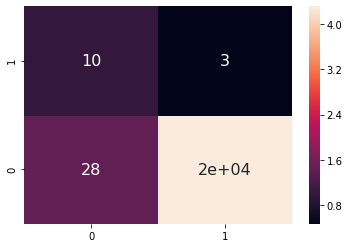

In [24]:
# Create confusion matrix
conf_matrix = np.array([[len(false_negative), len(true_negative)],
                       [len(true_positive), len(false_positive)]])

# Plot confusion matrix
fig, ax = plt.subplots()
_ = sns.heatmap(np.log10(conf_matrix), ax=ax, annot=conf_matrix, annot_kws={
    'size': 16, 'ha': 'center', 'va': 'center'
})
_ = ax.set_ylim(0, conf_matrix.shape[0])
_ = plt.show()